# Import Modules

In [29]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time
import copy
%matplotlib inline

# Assign Variables

In [134]:
training_filename = "data/training.csv"
testing_filename = "data/testing.csv"
lookup_tale_filename = "/data/IdLookupTable.csv"
batch_size =128

# Images are 96 x 96 grayscale with 15x2 features
image_size = 96
num_labels = 30
channels = 1

# Distort Input
flip_images = True
#Note implemented yet
brighten_images = True
contrast_images = True

# yay
model_filename = os.getcwd() + "/facedetectorwithdropout1000.ckpt"

# Load Data

In [3]:
def load(isTesting = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test     : optional, defaults to `False`
               Flag indicating if we need to load from `FTEST` (`True`) or FTRAIN (`False`)
    cols     : optional, defaults to `None`
               A list of columns you're interested in. If specified only returns these columns.
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    filename = testing_filename if isTesting else training_filename
    df = pd.read_csv(filename)  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not isTesting:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        #X, y = shuffle(X, y, random_state=42)  # shuffle train data
        random.seed(5)
        random.shuffle(X)
        y = y.astype(np.float32)
        random.seed(5)
        random.shuffle(y)
    else:
        y = None

    return X, y
# Wrapper for load() that reshapes the input to a image_size x image_size x channels
def loadData(isTesting = False):
    x_image, y_label = load(isTesting)
    x_image = x_image.reshape(-1, image_size, image_size, channels)
    return x_image, y_label

In [4]:
x_images, y_labels = loadData(False)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Separate Into Train Validate Test Sets

In [5]:
def splitData(data, percentage):
    data1 = data[:int(len(data)*percentage)]
    data2 = data[int(len(data)*percentage)+1:]
    
    return data1, data2

In [6]:
x_train, x_validate = splitData(x_images, 0.6)
y_train, y_validate = splitData(y_labels, 0.6)

#x_validate, x_test = splitData(x_validate, 0.5)
#y_validate, y_test = splitData(y_validate, 0.5)

In [24]:
flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

In [39]:
def batch(x_data,y_data=None, batches=1):
    x_temp = copy.deepcopy(x_data)
    y_temp = copy.deepcopy(y_data)
    length = len(x_temp)
    
        # flip images to add artificially inflate dataset
    if flip_images:
        # 50% chance to flip
        data_shape = x_temp.shape[0]
        indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
        x_temp[indices] = x_temp[indices, :, ::-1]

        if y_temp is not None:
            y_temp[indices, ::2] = y_temp[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in flip_indices:
                y_temp[indices, a], y_temp[indices, b] = (y_temp[indices, b], y_temp[indices, a])
      
    # return iterations
    for index in range(0, length, batches):
        if y_temp is None:
            yield x_temp[index:min(index + batches, length)]
        else:
            yield x_temp[index:min(index + batches, length)], y_temp[index:min(index + batches, length)]

# Build Convolutional Neural Network Model

In [8]:
def createConvolutionLayer(x_input, kernel_size, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, x_input.get_shape()[3], depth],
                             initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))
    
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    added = tf.nn.bias_add(convolution, biases)
    
    return tf.nn.relu(added)

In [9]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [10]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLu in graph
    # 
    
    return tf.nn.relu(x_input)

In [11]:
def createPoolingLayer(x_input, kernel_size):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    
    return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size,kernel_size, 1], padding='SAME')

In [12]:
def createNetwork1(x_input, isTraining):
    with tf.variable_scope('in'):
        x_input = tf.reshape(x_input, [-1, image_size*image_size])
    with tf.variable_scope('hidden'):
        hidden_fully_connected_layer = createFullyConnectedLayer(x_input, 100)
        relu_layer = createLinearRectifier(hidden_fully_connected_layer)
    with tf.variable_scope('out'):
        return createFullyConnectedLayer(relu_layer, 30)

In [160]:
def createNetwork2(x_input, isTraining):
    # createModel generates the entire model
    
    
    # Define convolution layers
    with tf.variable_scope('conv1'):
        convolution_layer1 = createConvolutionLayer(x_input, 3, 32)
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer1 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer1, keep_prob=.9), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        convolution_layer2 = createConvolutionLayer(pooling_layer1, 2, 64)
        pooling_layer2 = createPoolingLayer(convolution_layer2, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer2 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer2, keep_prob=.8), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        convolution_layer3 = createConvolutionLayer(pooling_layer2, 2, 128)
        pooling_layer3 = createPoolingLayer(convolution_layer3, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer3 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer3, keep_prob=.7), lambda: pooling_layer3)
    
    # Flatten output to connect to fully connected layers
    pooling_layer3_shape = pooling_layer3.get_shape().as_list()
    pooling_layer3_flattened = tf.reshape(pooling_layer3, [-1, pooling_layer3_shape[1] * pooling_layer3_shape[2] * pooling_layer3_shape[3]])
    
    # Define fully connected layers
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer3_flattened, 500)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        fully_connected_relu1 = tf.cond(isTraining, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob=0.5), lambda: fully_connected_relu1)
    with tf.variable_scope('fc2'):
        fully_connected_layer2 = createFullyConnectedLayer(fully_connected_relu1, 500)
        fully_connected_relu2 = createLinearRectifier(fully_connected_layer2)
    with tf.variable_scope('out'):
        output = createFullyConnectedLayer(fully_connected_relu2, num_labels)
        
    return output

In [14]:
def lossFunction(predict, actual):
    # calculates mean squared error
    return np.mean(np.square(predict - actual))

In [15]:
def distortImages(images):
    brightness_min = 1.0 - (50 / 100.0)
    brightness_max = 1.0 + (50 / 100.0)
    brightness_value = tf.random_uniform([image_size,image_size],
                                       minval=brightness_min,
                                       maxval=brightness_max)
    brightened_image = tf.multiply(images, brightness_value)
    return brightened_image

In [162]:
graph = tf.Graph()

with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1])
    y_output = tf.placeholder(tf.float32, shape=[None, num_labels])
    is_training = tf.placeholder(tf.bool)

    #current_epoch = tf.Variable(0)  # count the number of epochs
    
    num_epochs=1000
    global_step = tf.Variable(0, trainable=False)
    #learning rate
    learning_rate = tf.train.exponential_decay(.045, global_step, num_epochs, 0.75, staircase = True) 
    #learning_rate = 0.02
    #optimizer
    
    
    
    momentum_rate = 0.9 + (.099) * (global_step/num_epochs)
    #momentum_rate = 0.9
    
    # get model
    prediction_output = createNetwork2(x_input, is_training)
    
    #loss_function = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    loss_function = tf.reduce_mean(tf.square(prediction_output - y_output))
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(loss_function, global_step = global_step)
    #optimizer = tf.train.AdamOptimizer(learning_rate, 0.95).minimize(loss_function)

In [41]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.
    
    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session :
              TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.
               
    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_size = 128
    for step in range(int(X.shape[0] / batch_size)+1):    
        offset = step * batch_size 
        #batch_data = np.resize(X[offset:(offset + batch_size), ...], (batch_size, 9216))
        if offset+batch_size > X.shape[0]:
            batch_data = x_train[offset:X.shape[0], ...]
        else:
            batch_data = X[offset:(offset + batch_size), ...]
            
        [p_batch] = session.run([prediction_output], feed_dict = {
                x_input : batch_data,
                is_training : False
            }
        )
        #print(p_batch)
        p.extend(p_batch)
    return p

In [42]:
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

# Train CNN Model

In [163]:
start = time.time()
train_loss_list = []
valid_loss_list = []

with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for current_epoch in range(num_epochs):
        for batch_data, labels in batch(x_train, y_train, batch_size):
            feed_dict = {x_input: batch_data, y_output: labels, is_training: True}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)
            
        train_loss = lossFunction(get_predictions_in_batches(x_train, session), y_train)
        train_loss_list.append(train_loss)
        valid_loss = lossFunction(get_predictions_in_batches(x_validate, session), y_validate)
        valid_loss_list.append(valid_loss)
        if(current_epoch % 10 == 0):
            # validate every so often
            
            current_time = time.time() - start
            hours, minutes, seconds = getTime(current_time)
            
            print("Epoch[%4d]" % current_epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f" % train_loss + " %f" % valid_loss + " %f" % learning_rate.eval())
            
        # Evaluate on test dataset.
    test_loss = lossFunction(get_predictions_in_batches(x_validate, session), y_validate)
    print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) 
    save_path = saver.save(session, model_filename)

Epoch[   0]0: 0: 1 0.027979 0.028458 0.045000
Epoch[  10]0: 0:11 0.004324 0.005108 0.045000
Epoch[  20]0: 0:22 0.003360 0.003960 0.045000
Epoch[  30]0: 0:32 0.003214 0.003785 0.045000
Epoch[  40]0: 0:43 0.003120 0.003667 0.045000
Epoch[  50]0: 0:53 0.003008 0.003539 0.045000
Epoch[  60]0: 1: 4 0.002955 0.003479 0.045000
Epoch[  70]0: 1:14 0.002864 0.003421 0.045000
Epoch[  80]0: 1:25 0.002760 0.003342 0.045000
Epoch[  90]0: 1:35 0.002608 0.003249 0.033750
Epoch[ 100]0: 1:45 0.002282 0.003095 0.033750
Epoch[ 110]0: 1:56 0.002147 0.003005 0.033750
Epoch[ 120]0: 2: 6 0.003736 0.004139 0.033750
Epoch[ 130]0: 2:17 nan nan 0.033750
Epoch[ 140]0: 2:27 nan nan 0.033750
Epoch[ 150]0: 2:37 nan nan 0.033750
Epoch[ 160]0: 2:48 nan nan 0.033750


KeyboardInterrupt: 

In [ ]:
##############################################################################
#
# A simple example of converting a Pandas dataframe to an xlsx file using
# Pandas and XlsxWriter.
#
# Copyright 2013-2016, John McNamara, jmcnamara@cpan.org
#

import pandas as pd


# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Training': train_loss_list, 'Validation:', valid_loss_list})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

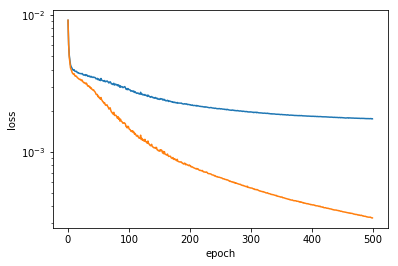

In [130]:
x = np.linspace(0, len(valid_loss_list)-1, len(valid_loss_list))
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x, valid_loss_list, x, train_loss_list)

In [65]:
x.shape

(1,)

# Compare Labels

In [131]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    load_path = saver.restore(session, model_filename)
    [p] = session.run([prediction_output], feed_dict={x_input: x_validate, is_training:False})

# Ouput Test Example Images

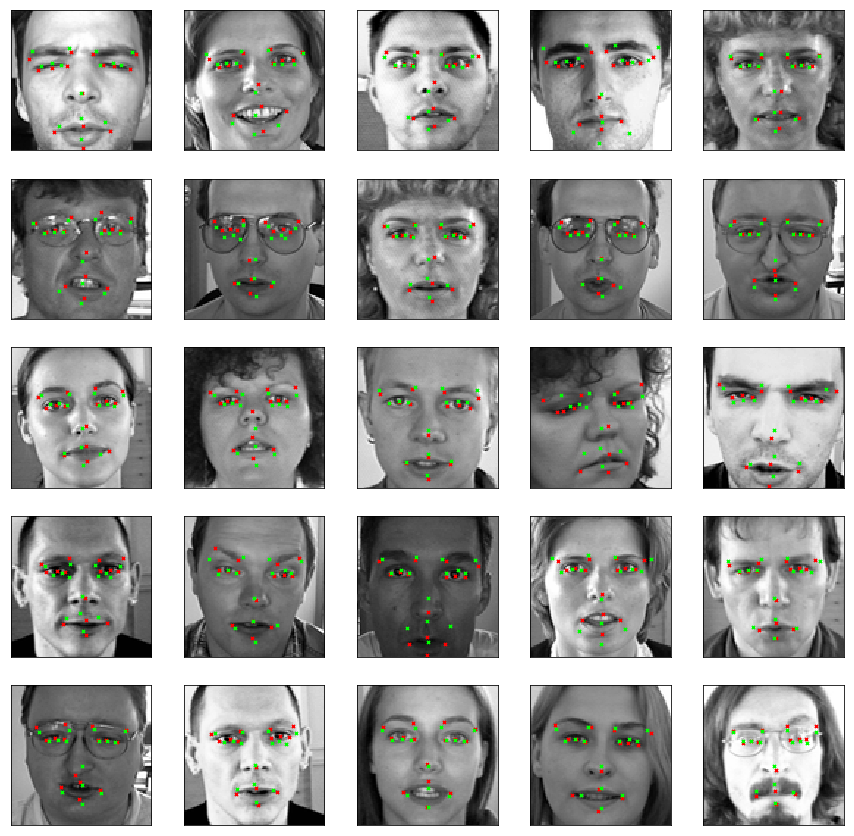

In [126]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = x_validate[i]
    img = img.reshape(96, 96)
    y = y_validate[i]
    y2 = p[i]
    axis.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

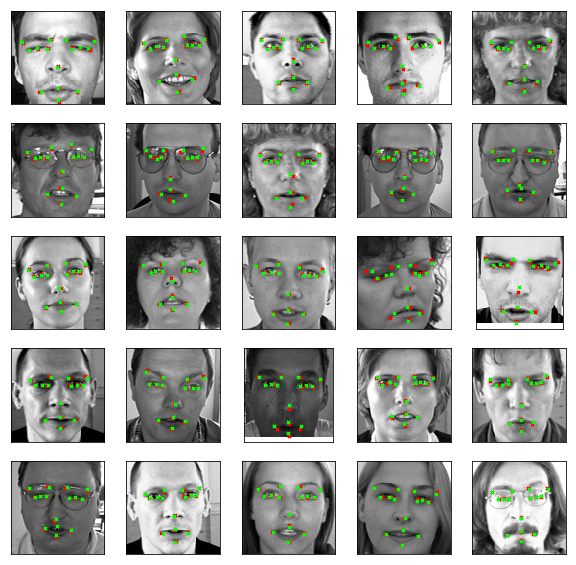

In [132]:
fig = plt.figure(figsize=(10, 10))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = x_validate[i]
    img = img.reshape(96, 96)
    y = y_validate[i]
    y2 = p[i]
    axis.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

In [94]:
ytep = p[i]
print(ytep)
print(y_validate[i])

[ 0.16724212 -0.12088959 -0.16861415 -0.10155347  0.11148646 -0.10869996
  0.2216377  -0.11860277 -0.11617339 -0.09563975 -0.22303134 -0.09562717
  0.09235942 -0.19951621  0.28849119 -0.20414059 -0.08455247 -0.1826176
 -0.29577428 -0.17267436  0.01063365  0.101422    0.1444699   0.27571031
 -0.13072236  0.28950578  0.0099463   0.24055892  0.00990708  0.33943534]
[ 0.34485507 -0.23907971 -0.32875362 -0.20669565  0.21668115 -0.21794347
  0.44847825 -0.23907971 -0.2315942  -0.19374058 -0.45181158 -0.18726377
  0.17782609 -0.42013913  0.58449274 -0.42691013 -0.17330435 -0.36861885
 -0.58782607 -0.34918696  0.021       0.20135072  0.28655073  0.55110145
 -0.26398551  0.57701451  0.01452174  0.50576812  0.02236232  0.68613046]


In [ ]:
X, y = loadData()
X_flipped = X[:, :, :, ::-1]  # simple slice to flip all images

# plot two images:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
pyplot.show()

In [ ]:
X, y = loadData()

(1, 30)


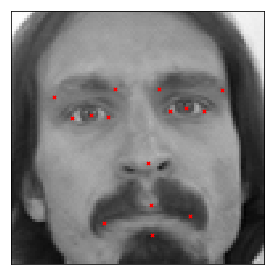

(1, 30)


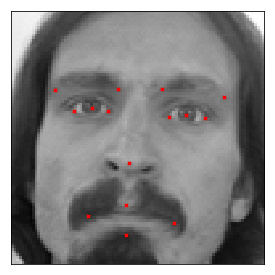

(1, 30)


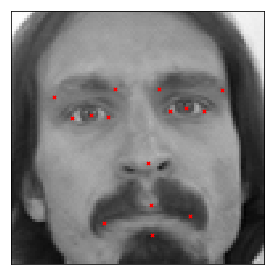

(1, 30)


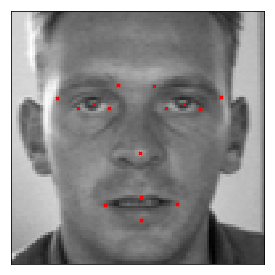

(1, 30)


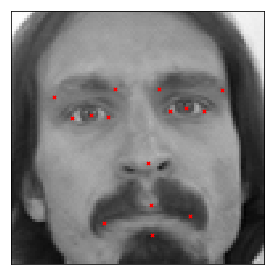

(1, 30)


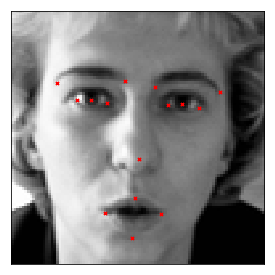

(1, 30)


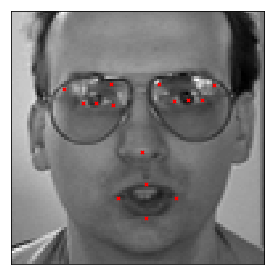

(1, 30)


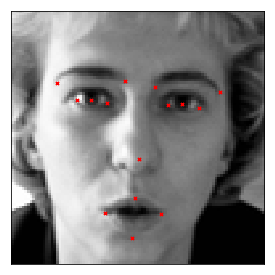

(1, 30)


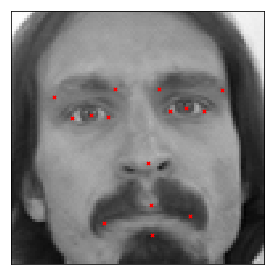

(1, 30)


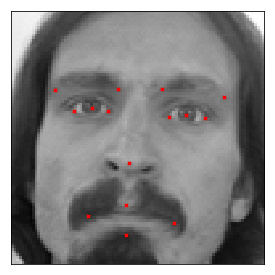

(1, 30)


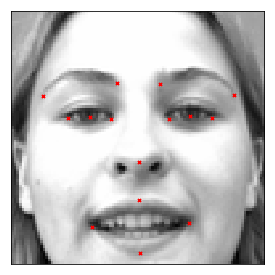

(1, 30)


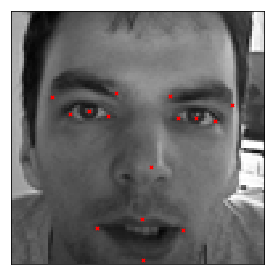

(1, 30)


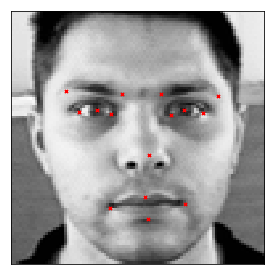

(1, 30)


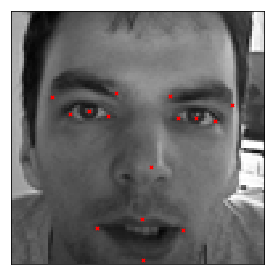

(1, 30)


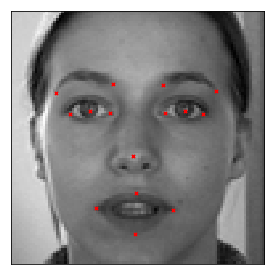

(1, 30)


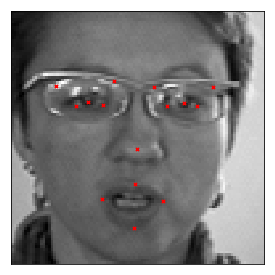

(1, 30)


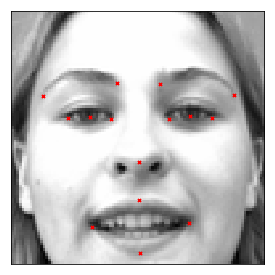

(1, 30)


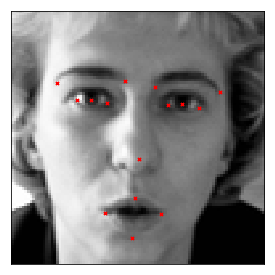

(1, 30)


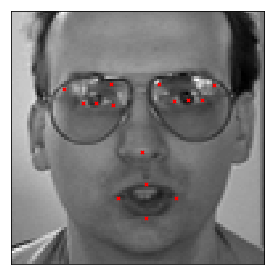

(1, 30)


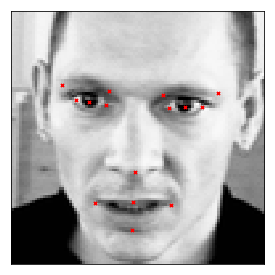

(1, 30)


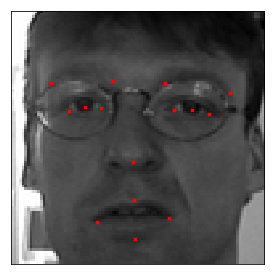

(1, 30)


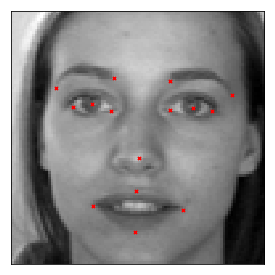

(1, 30)


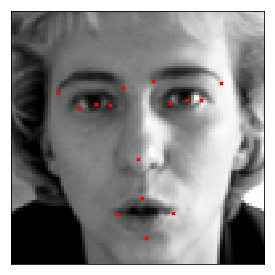

(1, 30)


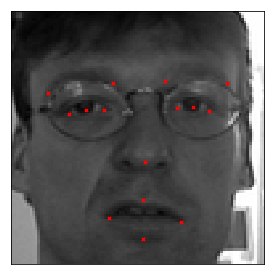

(1, 30)


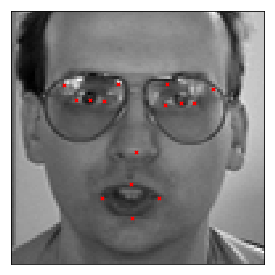

(1, 30)


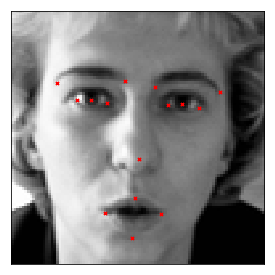

(1, 30)


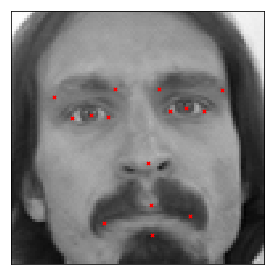

(1, 30)


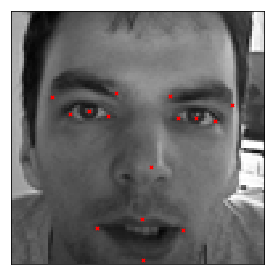

(1, 30)


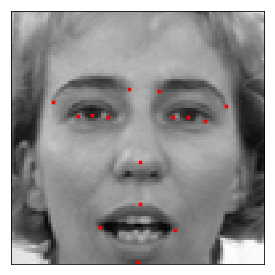

(1, 30)


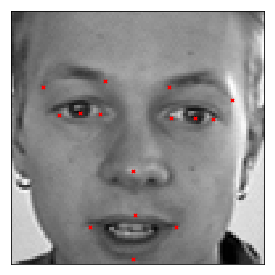

(1, 30)


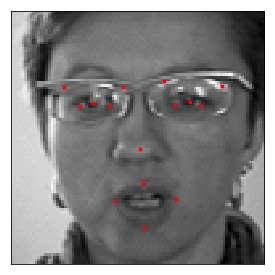

(1, 30)


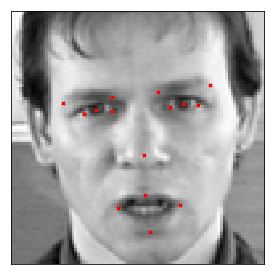

(1, 30)


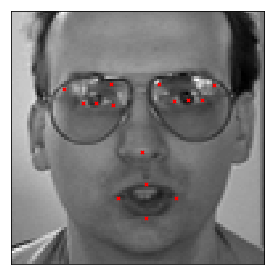

(1, 30)


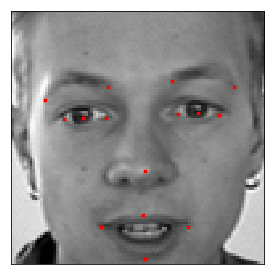

(1, 30)


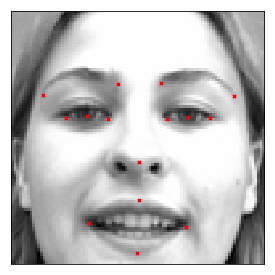

(1, 30)


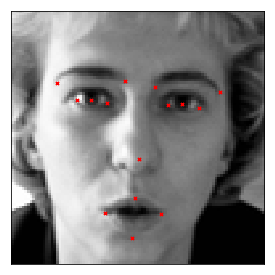

(1, 30)


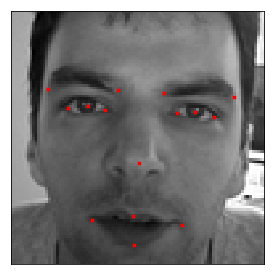

(1, 30)


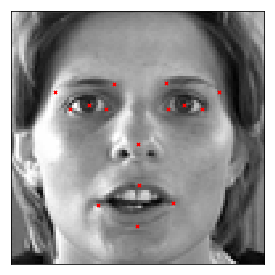

(1, 30)


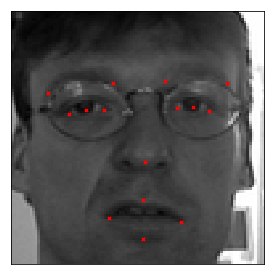

(1, 30)


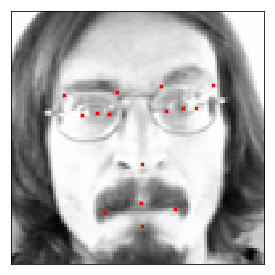

(1, 30)


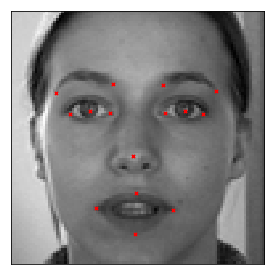

(1, 30)


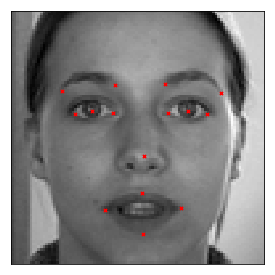

(1, 30)


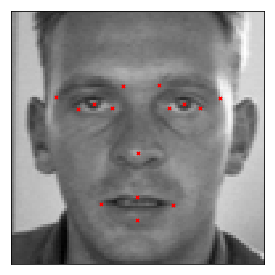

(1, 30)


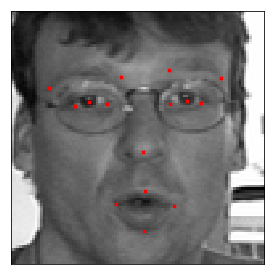

(1, 30)


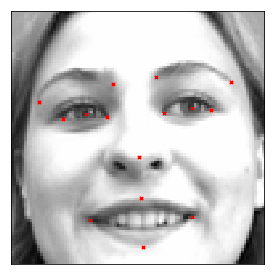

(1, 30)


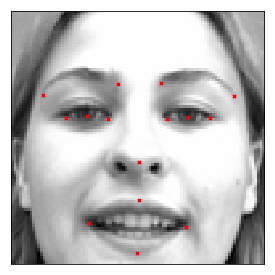

(1, 30)


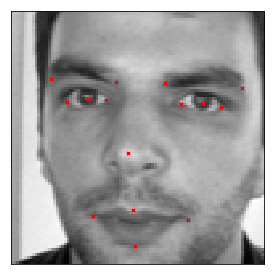

(1, 30)


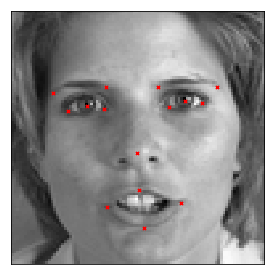

(1, 30)


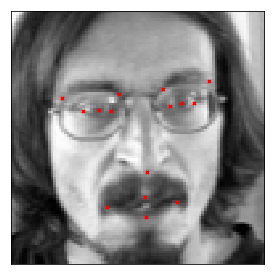

(1, 30)


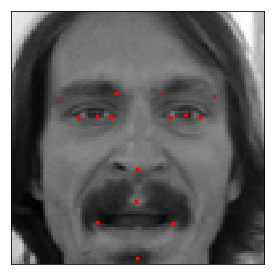

(1, 30)


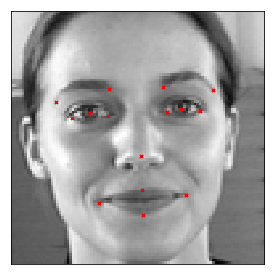

(1, 30)


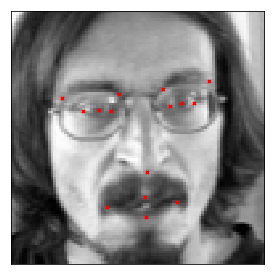

(1, 30)


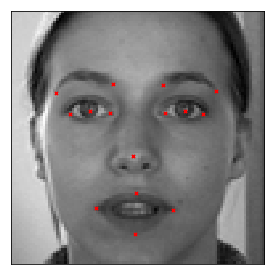

(1, 30)


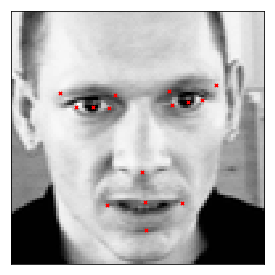

(1, 30)


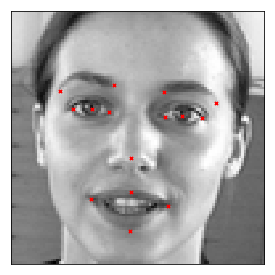

(1, 30)


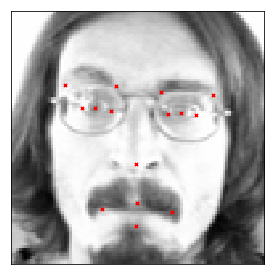

(1, 30)


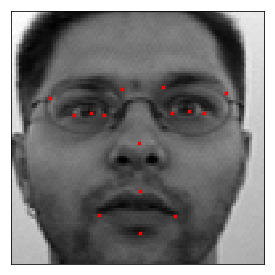

(1, 30)


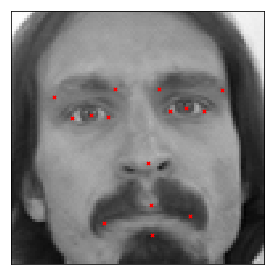

(1, 30)


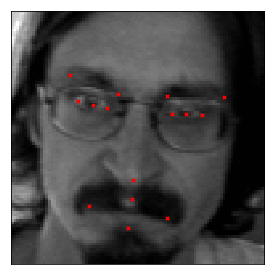

(1, 30)


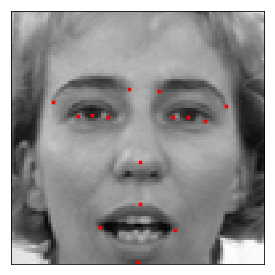

(1, 30)


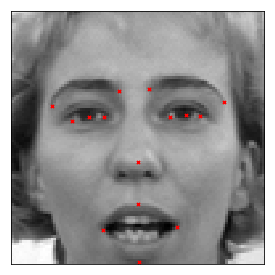

(1, 30)


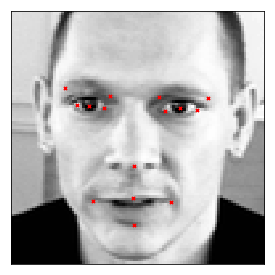

(1, 30)


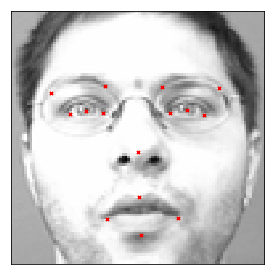

(1, 30)


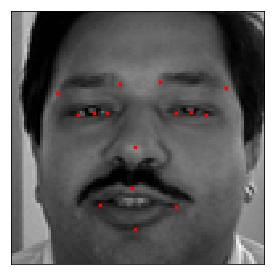

(1, 30)


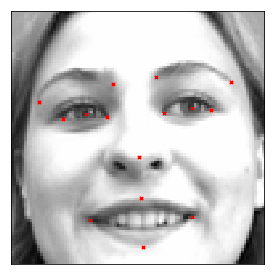

(1, 30)


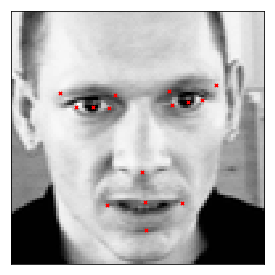

(1, 30)


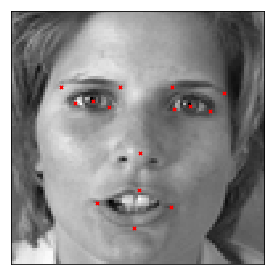

(1, 30)


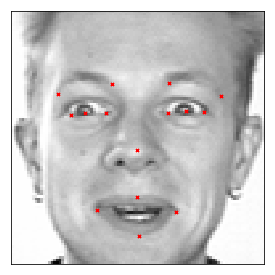

(1, 30)


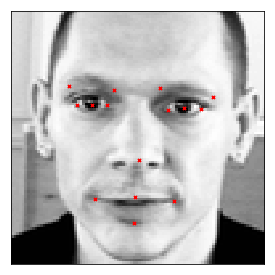

(1, 30)


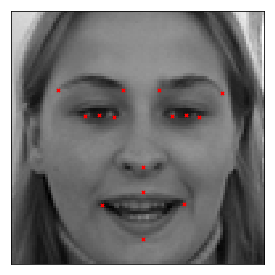

(1, 30)


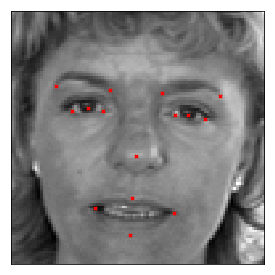

(1, 30)


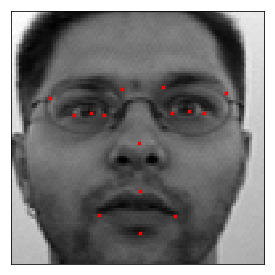

(1, 30)


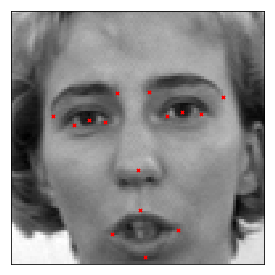

(1, 30)


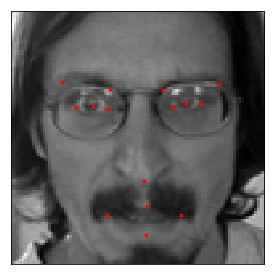

(1, 30)


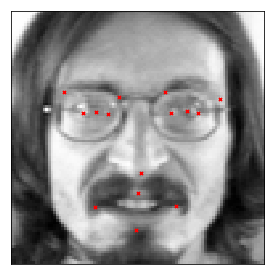

(1, 30)


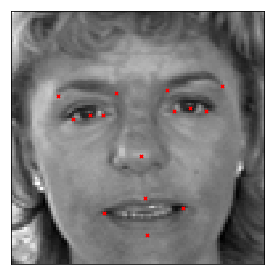

(1, 30)


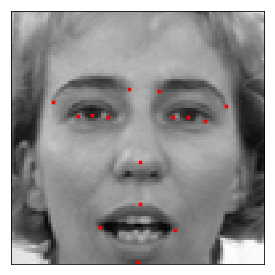

(1, 30)


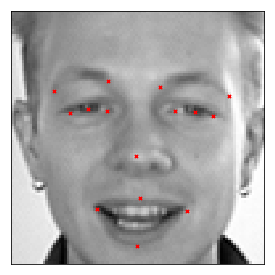

(1, 30)


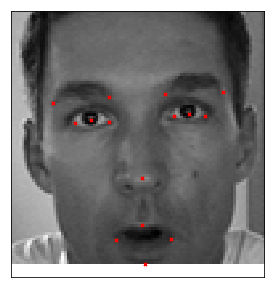

(1, 30)


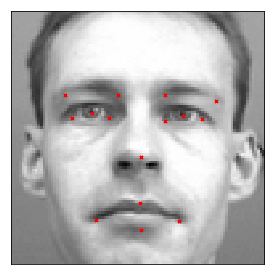

(1, 30)


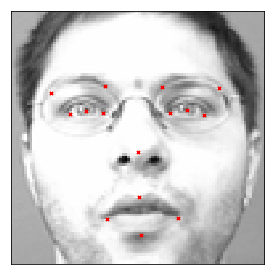

(1, 30)


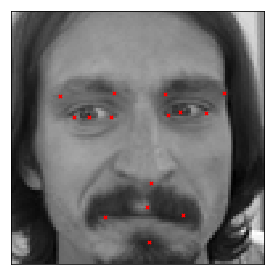

(1, 30)


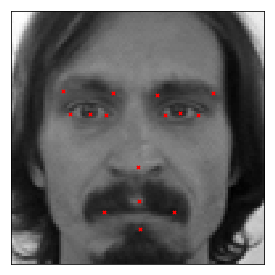

(1, 30)


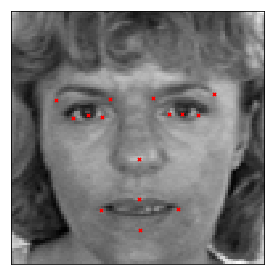

(1, 30)


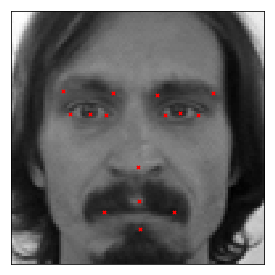

(1, 30)


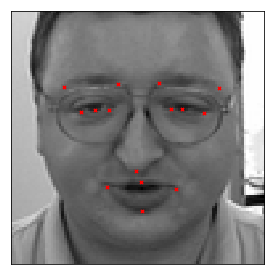

(1, 30)


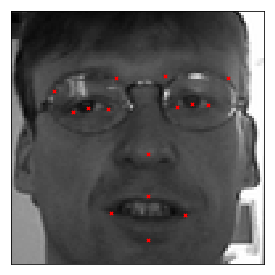

(1, 30)


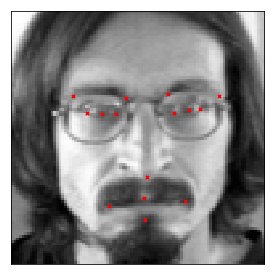

(1, 30)


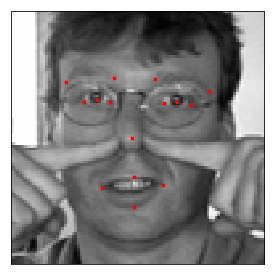

(1, 30)


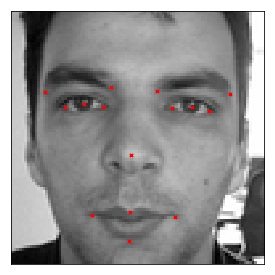

(1, 30)


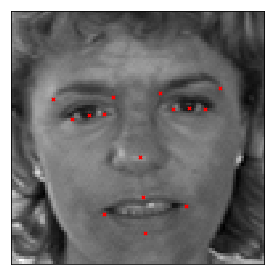

(1, 30)


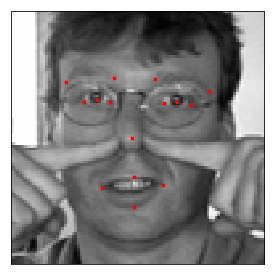

(1, 30)


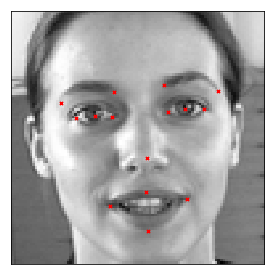

(1, 30)


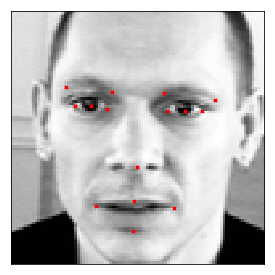

(1, 30)


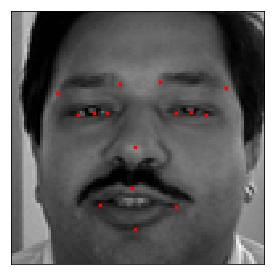

(1, 30)


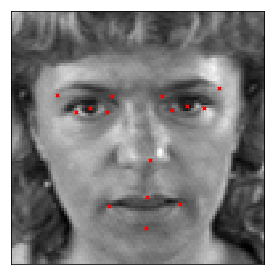

(1, 30)


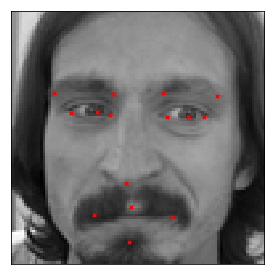

(1, 30)


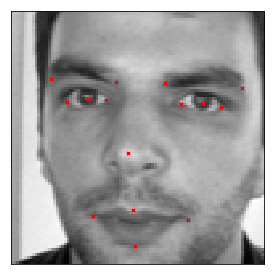

(1, 30)


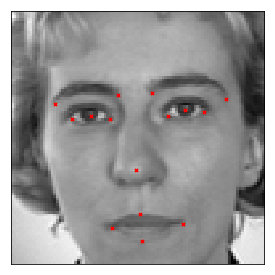

(1, 30)


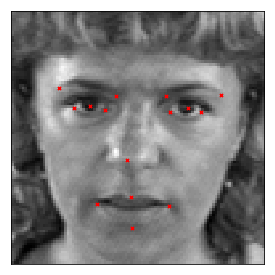

(1, 30)


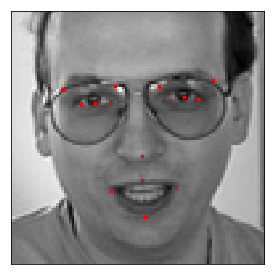

(1, 30)


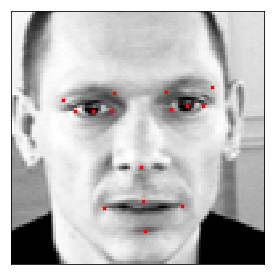

(1, 30)


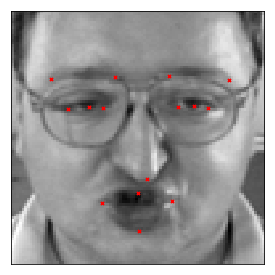

(1, 30)


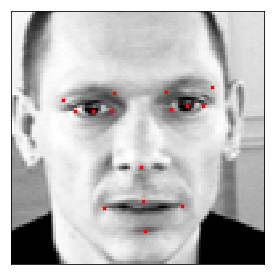

(1, 30)


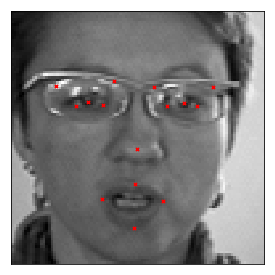

(1, 30)


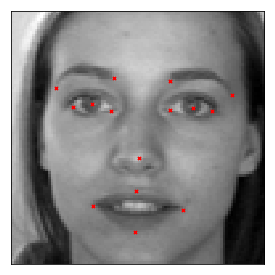

(1, 30)


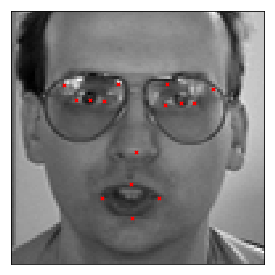

(1, 30)


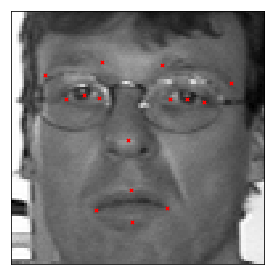

(1, 30)


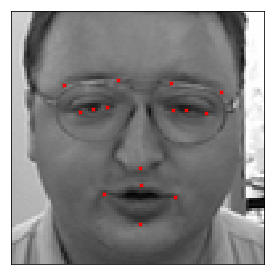

(1, 30)


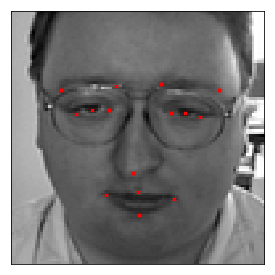

(1, 30)


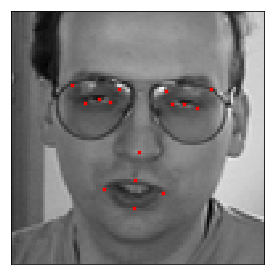

(1, 30)


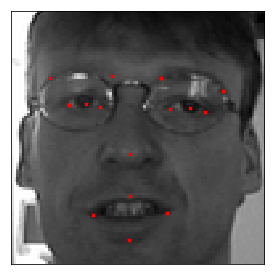

(1, 30)


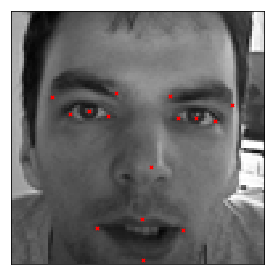

(1, 30)


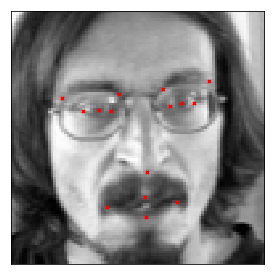

(1, 30)


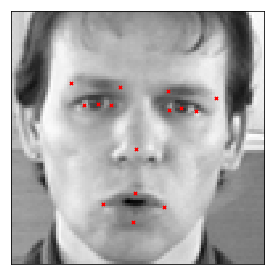

(1, 30)


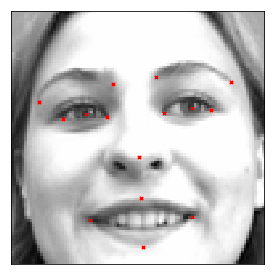

(1, 30)


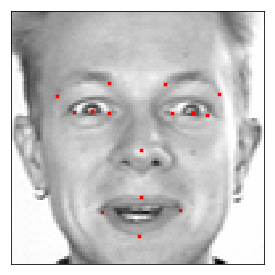

(1, 30)


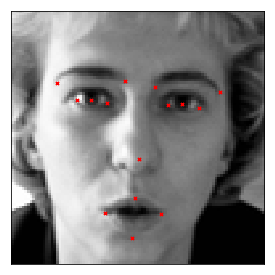

(1, 30)


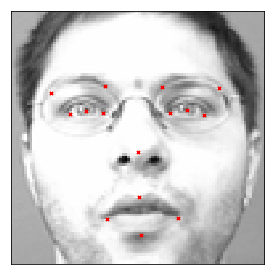

(1, 30)


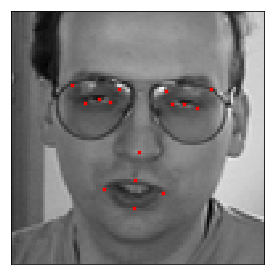

(1, 30)


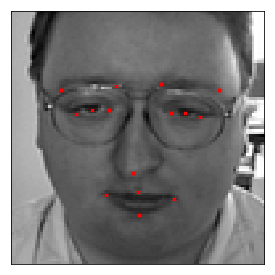

(1, 30)


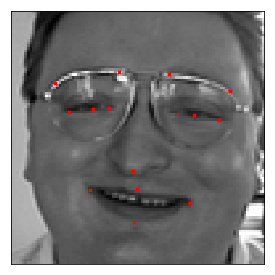

(1, 30)


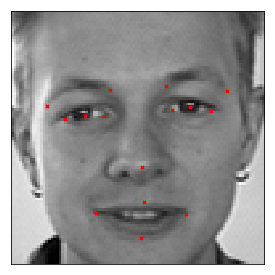

(1, 30)


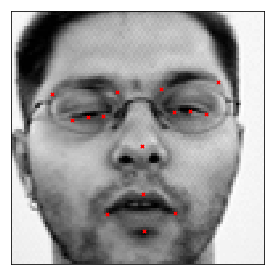

(1, 30)


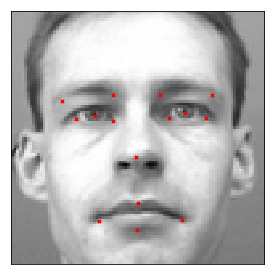

(1, 30)


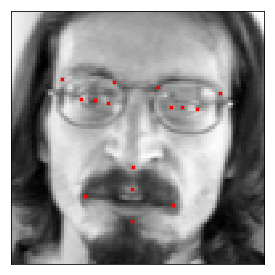

(1, 30)


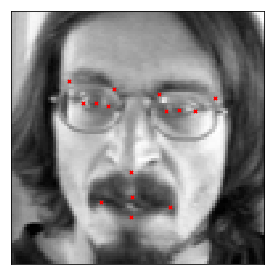

(1, 30)


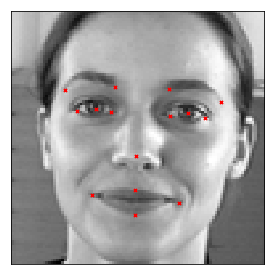

(1, 30)


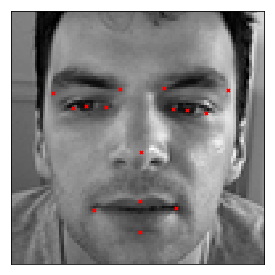

(1, 30)


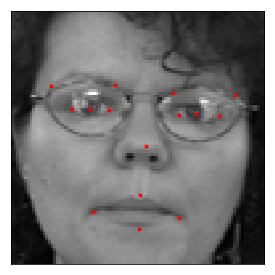

(1, 30)


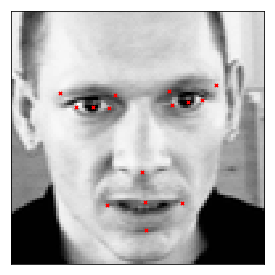

(1, 30)


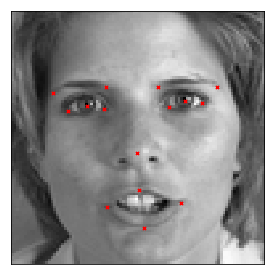

(1, 30)


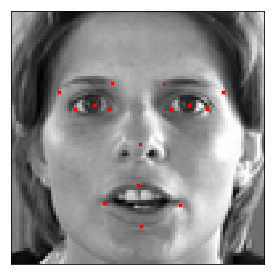

(1, 30)


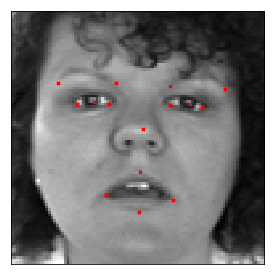

(1, 30)


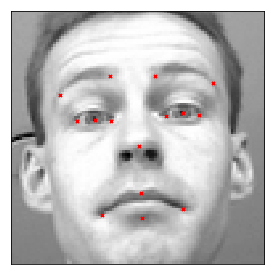

(1, 30)


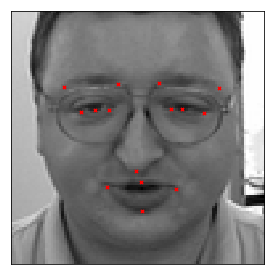

(1, 30)


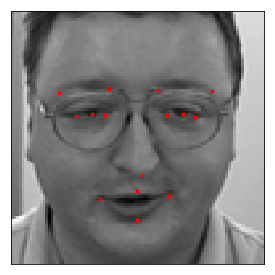

(1, 30)


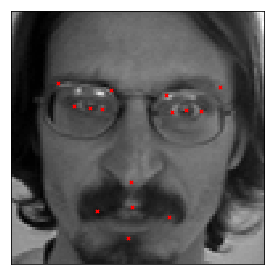

(1, 30)


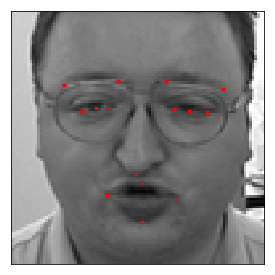

(1, 30)


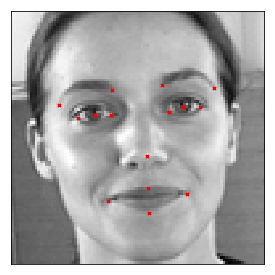

(1, 30)


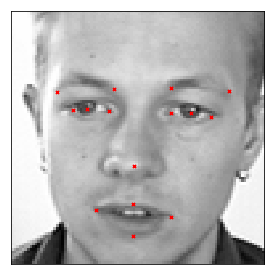

(1, 30)


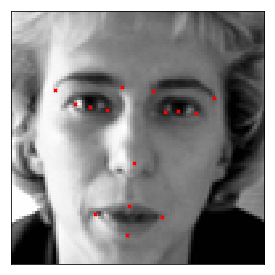

(1, 30)


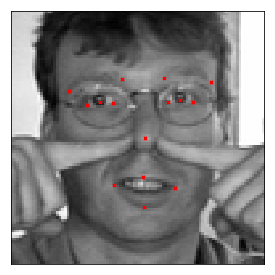

(1, 30)


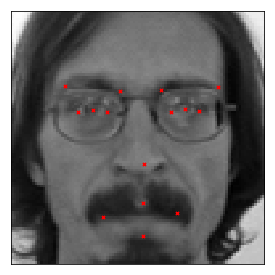

(1, 30)


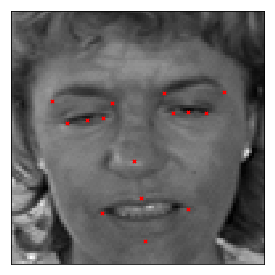

(1, 30)


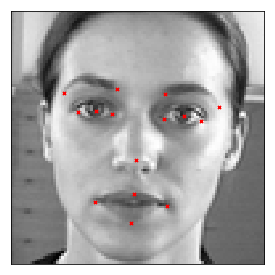

(1, 30)


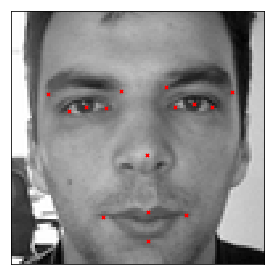

(1, 30)


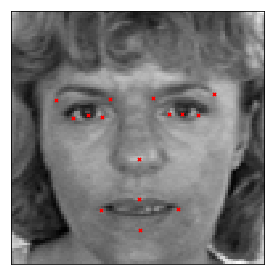

(1, 30)


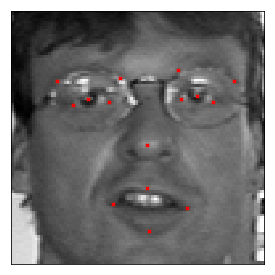

(1, 30)


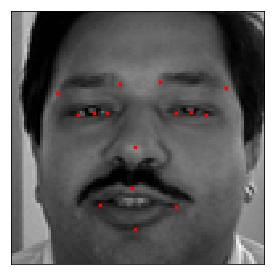

(1, 30)


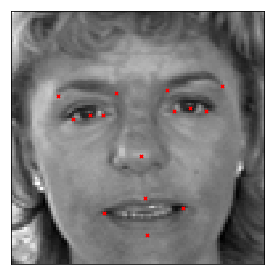

(1, 30)


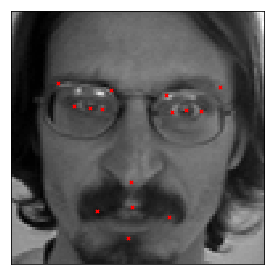

(1, 30)


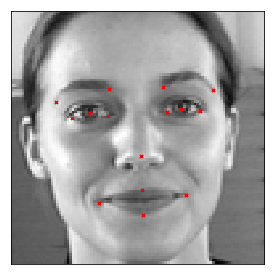

(1, 30)


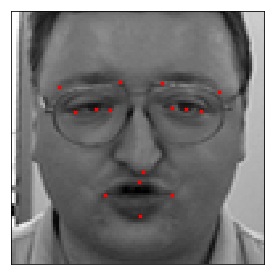

(1, 30)


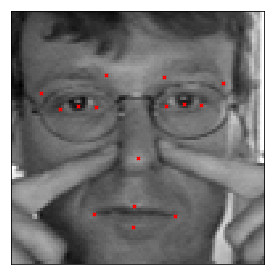

(1, 30)


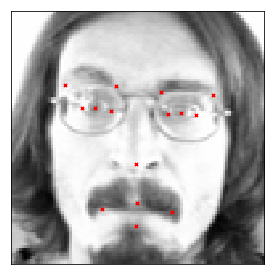

(1, 30)


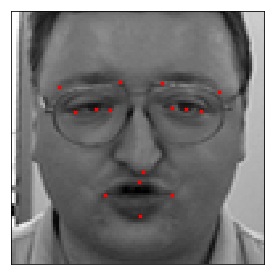

(1, 30)


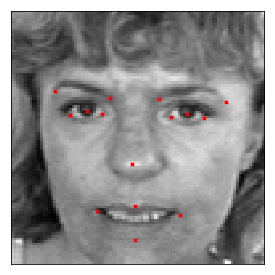

(1, 30)


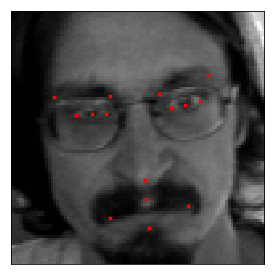

(1, 30)


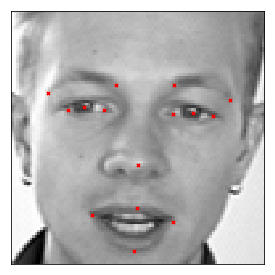

(1, 30)


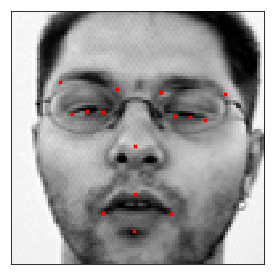

(1, 30)


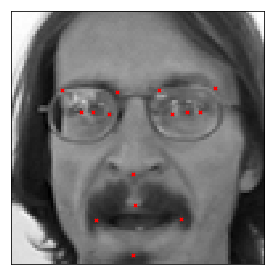

(1, 30)


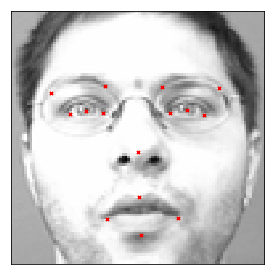

(1, 30)


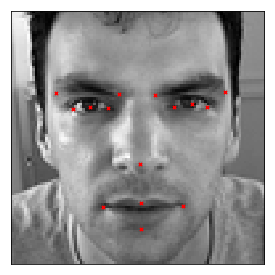

(1, 30)


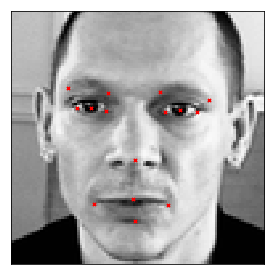

(1, 30)


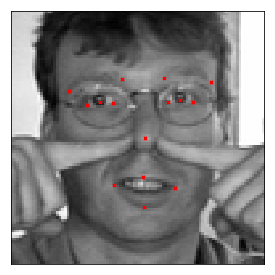

(1, 30)


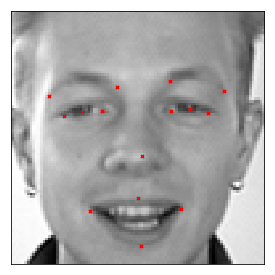

(1, 30)


KeyboardInterrupt: 

In [51]:
flip_images = True
for x, labels in batch(X, y, 1):
    print(labels.shape)
    labels = labels.reshape(30, 1)
    img = x
    img = img.reshape(96, 96)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    ax.imshow(img, cmap='gray')
    ax.scatter(labels[0::2] * 48 + 48, labels[1::2] * 48 + 48, marker='x', s=10, color='red')
    plt.show()

In [128]:
flip_images